In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1950_bacteria_4881.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1430-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1437-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg
/kaggle/input/chest-xray-pneumo

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPooling2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [3]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 180
def datafunc(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                img_arr = cv2.cvtColor(img_arr,cv2.COLOR_GRAY2RGB)               
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) 
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [4]:
train = datafunc('../input/chest-xray-pneumonia/chest_xray/chest_xray/train')
test = datafunc('../input/chest-xray-pneumonia/chest_xray/chest_xray/test')
val = datafunc('../input/chest-xray-pneumonia/chest_xray/chest_xray/val')

OpenCV(4.3.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.3.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.3.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.3.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



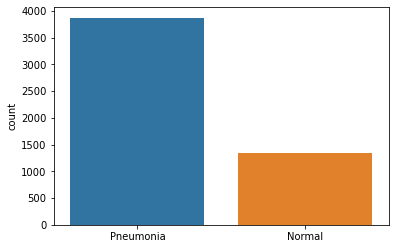

In [5]:
trainlabel = []
for img in train:
    if(img[1] == 0):
        trainlabel.append("Pneumonia")
    else:
        trainlabel.append("Normal")
sns.countplot(trainlabel) 

Text(0.5, 1.0, 'NORMAL')

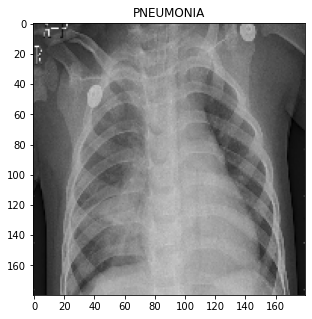

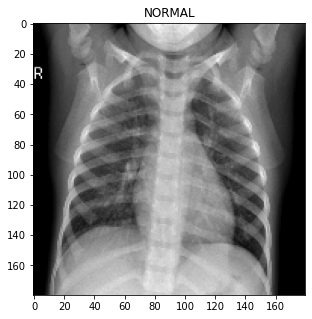

In [6]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [7]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [8]:
x_train = np.array(x_train)/255.0
x_test = np.array(x_test)/255.0
x_val = np.array(x_val)/255.0

In [9]:
x_train = (x_train.reshape(-1,img_size,img_size,3))
x_test = (x_test.reshape(-1,img_size,img_size,3))
x_val = (x_val.reshape(-1,img_size,img_size,3))
x_train.shape

(5216, 180, 180, 3)

In [10]:
y_train=np.array(y_train)
y_test=np.array(y_test)
y_val=np.array(y_val)

In [11]:
base_model = keras.applications.VGG16(weights='imagenet', 
                                include_top=False, 
                                input_shape=(180,180,3))
base_model.trainable = False

58892288/58889256 [==============================] - 2s 0us/step


In [12]:
from keras.models import Sequential
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from keras import applications
input_shape = (180,180,3)

x = base_model.output
x= Flatten()(x)
x= Dense(512,activation='relu')(x)
x= BatchNormalization()(x)
x=Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)
for layer in base_model.layers:
    layer.trainable = False
model=Sequential()
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-3),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 90, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 45, 128)       0     

In [14]:
from tensorflow.keras.utils import plot_model

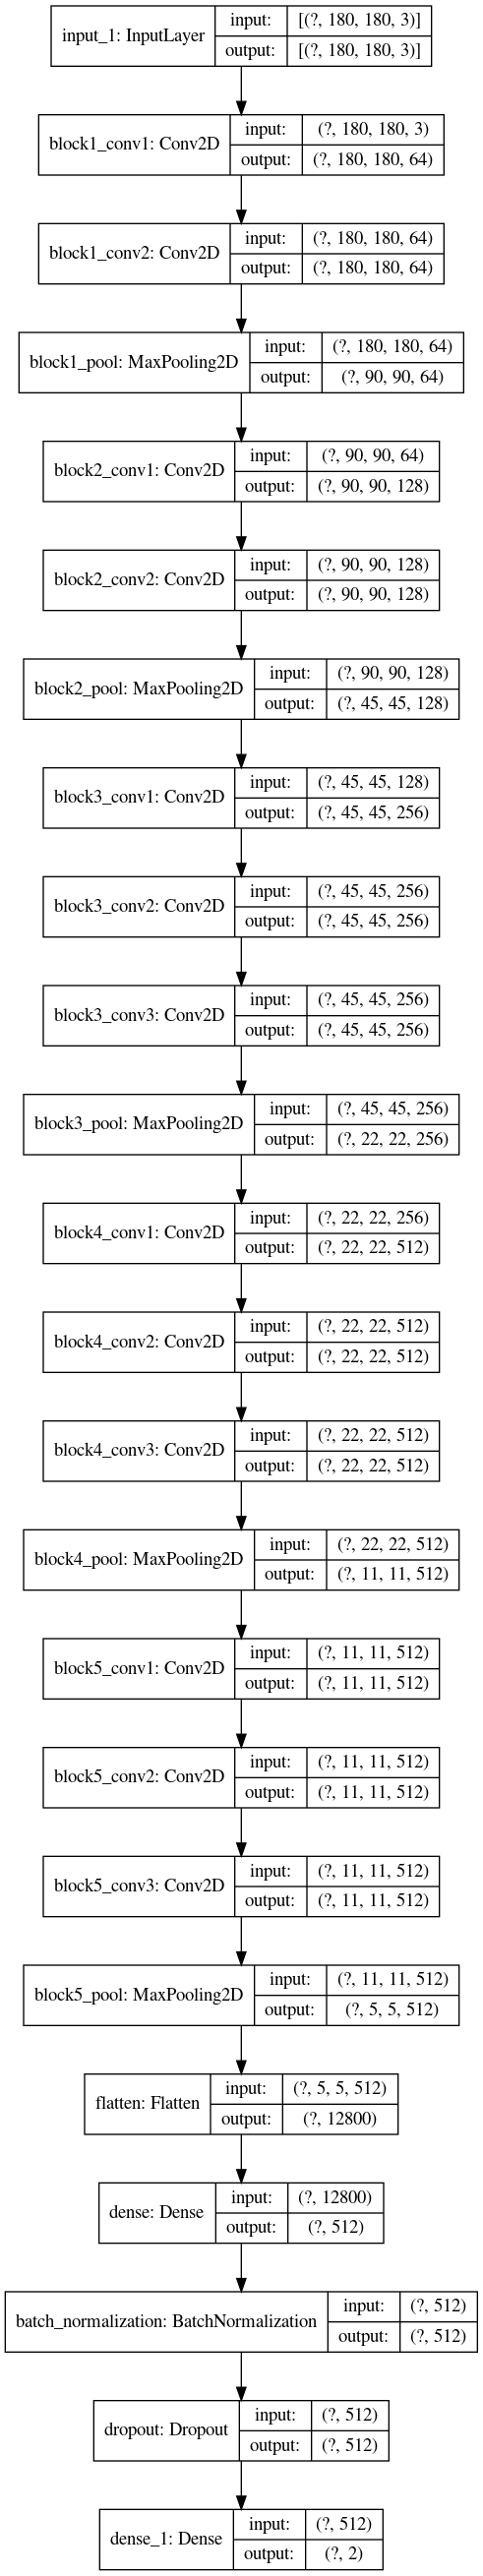

In [15]:
plot_model(model, show_shapes=True, to_file='model_vgg16.png')

In [16]:
datagen= ImageDataGenerator(zoom_range=0.1)

In [17]:
datagen.fit(x_train)

In [18]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
history = model.fit(datagen.flow(x_train,
                                 y_train,
                                 batch_size = 64) ,
                    epochs = 5 ,
                    validation_data = datagen.flow(x_test, y_test))

Epoch 1/5
82/82 [==============================] - 687s 8s/step - loss: 0.2273 - accuracy: 0.9283 - val_loss: 1.2911 - val_accuracy: 0.7051
Epoch 2/5
82/82 [==============================] - 684s 8s/step - loss: 0.0863 - accuracy: 0.9689 - val_loss: 0.5286 - val_accuracy: 0.8494
Epoch 3/5
82/82 [==============================] - 683s 8s/step - loss: 0.0794 - accuracy: 0.9682 - val_loss: 0.3676 - val_accuracy: 0.8942
Epoch 4/5
82/82 [==============================] - 683s 8s/step - loss: 0.0680 - accuracy: 0.9739 - val_loss: 0.9302 - val_accuracy: 0.7981
Epoch 5/5
82/82 [==============================] - 685s 8s/step - loss: 0.0562 - accuracy: 0.9808 - val_loss: 0.5893 - val_accuracy: 0.8462


In [19]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool


In [20]:
for layer in model.layers[:12]:
    layer.trainable = False
for layer in model.layers[12:]:
    layer.trainable = True

In [21]:
model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizers.Adam(lr=1e-3),metrics=['accuracy'])
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=1, mode='auto')
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 3 , validation_data = datagen.flow(x_test, y_test),callbacks=[checkpoint,early])

Epoch 1/3
163/163 [==============================] - 1112s 7s/step - loss: 0.2178 - accuracy: 0.9197 - val_loss: 10.8041 - val_accuracy: 0.3750
Epoch 2/3
163/163 [==============================] - 1107s 7s/step - loss: 0.1214 - accuracy: 0.9540 - val_loss: 7.9062 - val_accuracy: 0.6250
Epoch 3/3
163/163 [==============================] - 1109s 7s/step - loss: 0.1082 - accuracy: 0.9603 - val_loss: 0.2796 - val_accuracy: 0.9071


In [22]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")


20/20 [==============================] - 67s 3s/step - loss: 0.2279 - accuracy: 0.9263
Loss of the model is -  0.22789786756038666
20/20 [==============================] - 68s 3s/step - loss: 0.2279 - accuracy: 0.9263
Accuracy of the model is -  92.62820482254028 %


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


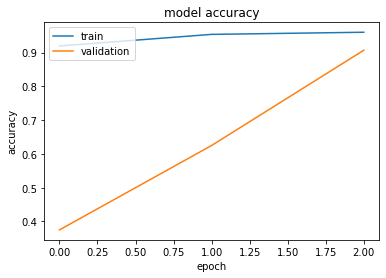

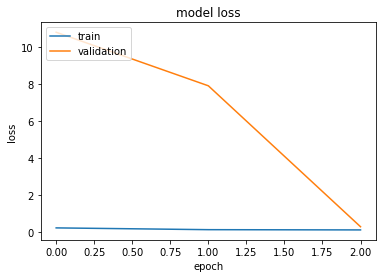

In [23]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [24]:
predictions = model.predict(x_test)
predictions = predictions[:,0]
i=0
for i in range(len(predictions)):
    if predictions[i]>0.50:
        predictions[i]=0
    else:
        predictions[i]=1

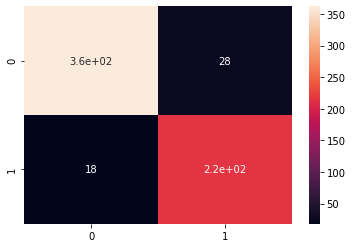

In [25]:
cm = confusion_matrix(y_test,predictions)
sns.heatmap(cm, annot=True)

In [26]:
cm

array([[362,  28],
       [ 18, 216]])

In [27]:
(cm[0][0]+cm[1][1])/624

0.9262820512820513

In [28]:
from sklearn.metrics import precision_score , recall_score
print(precision_score(y_test,predictions,average=None))
print(recall_score(y_test,predictions,average=None))

[0.95263158 0.8852459 ]
[0.92820513 0.92307692]


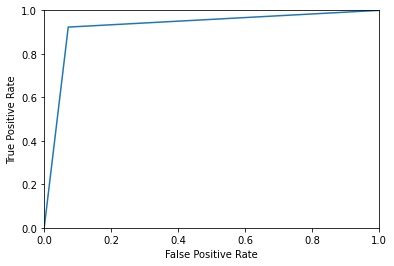

0.9256410256410257


In [29]:
from sklearn.metrics import roc_curve,roc_auc_score
fpr , tpr , thresholds = roc_curve ( y_test , predictions)
def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()    
  
plot_roc_curve (fpr,tpr) 
auc_score=roc_auc_score(y_test , predictions)  
print(auc_score)